# Projet 6 : Classifiez automatiquement des biens de consommation.

## Prétraitement, feature extraction et faisabilité / techniques avancées

* [1. Contexte](#partie1)
* [2. Préparation de l'environnement](#partie2)
    * [2.1 Préparation des données](#partie2.1)
    * [2.1 Répertoire des fonctions](#partie2.1)
* [3. Prétraitement des données textuelles](#partie3)
    * [3.1 Données textuelles : description](#partie3.1)
      * [3.1.1 Word2Vec](#partie3.1.1)
      * [3.1.2 BERT](#partie3.1.2)
      * [3.1.3 USE](#partie3.1.3)
    * [3.2 Données textuelles : product_name + description](#partie3.2)
      * [3.2.1 Word2Vec](#partie3.2.1)
      * [3.2.2 BERT](#partie3.2.2)
      * [3.2.3 USE](#partie3.2.3)
* [4. Conclusion](#partie4)

## <font color='red'>1. Contexte</font><a class="anchor" id="partie1"></a>

Dans la continuité de l'analyse de faisabilité entreprise lors du premier livrable, l'objectif de cette étape est d'approfondir l'analyse des descriptions textuelles en appliquant des techniques avancées de traitement du langage naturel (NLP) pour l'extraction de features. En particulier, ce livrable se concentre sur l'utilisation de méthodes d'embeddings plus sophistiquées pour mieux représenter le contenu textuel des descriptions de produits.

Les principales étapes de ce livrable sont les suivantes :

- Prétraitement des données textuelles : Même approche que précédemment, avec nettoyage, lemmatisation et tokenisation, mais cette fois appliquée avant la génération des embeddings.
- Extraction des features via embeddings avancés : Utilisation des techniques telles que Word2Vec, BERT et Universal Sentence Encoder (USE) pour transformer les descriptions en vecteurs plus riches en informations sémantiques.
- Réduction de dimension et clustering : Application des méthodes ACP, T-SNE et K-Means sur ces nouveaux vecteurs d'embeddings, avec une comparaison des résultats à l'aide de l'Adjusted Rand Index (ARI).
- Comparaison des résultats : Comparaison des résultats obtenus avec les techniques d'embeddings avancées par rapport aux méthodes plus simples utilisées dans le premier livrable, comme Bag of Words et TF-IDF.

Ce livrable vise à évaluer si ces méthodes avancées permettent de mieux regrouper les produits en fonction de leur catégorie réelle, et si les clusters obtenus révèlent des patterns plus clairs que ceux obtenus précédemment.

## <font color='red'>2. Préparation de l'environnement</font><a class="anchor" id="partie2"></a>

### <font color='blue'>2.1 Préparation des données</font><a class="anchor" id="partie2.1">

In [ ]:
!pip install transformers

In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install tensorflow tensorflow-hub

In [ ]:
import pandas as pd
import numpy as np
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
from sentence_transformers import SentenceTransformer
import tensorflow_hub as hub

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Charger le fichier CSV dans un data frame
df = pd.read_csv('/content/drive/My Drive/projet_6/df_classification_copy.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   cat_1              1050 non-null   object
 1   cat_2              1050 non-null   object
 2   image              1050 non-null   object
 3   product_name       1050 non-null   object
 4   description        1050 non-null   object
 5   combined_text      1050 non-null   object
 6   descr_bow          1050 non-null   object
 7   descr_bow_lem      1050 non-null   object
 8   descr_bow_stem     1050 non-null   object
 9   combined_bow       1050 non-null   object
 10  combined_bow_lem   1050 non-null   object
 11  combined_bow_stem  1050 non-null   object
dtypes: object(12)
memory usage: 98.6+ KB


In [ ]:
df.head(5)

,cat_1,cat_2,image,product_name,description,combined_text,descr_bow,descr_bow_lem,descr_bow_stem,combined_bow,combined_bow_lem,combined_bow_stem
0,Home Furnishing,Curtains & Accessories,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Elegance Polyester Multicolor Abstract Eyelet ...,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key featur eleg polyest multicolor abstract ey...,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,eleg polyest multicolor abstract eyelet door c...
1,Baby Care,Baby Bath & Skin,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas Cotton Bath Towel Specifications of S...,specifications sathiyas cotton bath towel 3 ba...,specification sathiyas cotton bath towel 3 bat...,specif sathiya cotton bath towel 3 bath towel ...,sathiyas cotton bath towel specifications sath...,sathiyas cotton bath towel specification sathi...,sathiya cotton bath towel specif sathiya cotto...
2,Baby Care,Baby Bath & Skin,64d5d4a258243731dc7bbb1eef49ad74.jpg,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa Cotton Terry Face Towel Set Key Featur...,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key featur eurospa cotton terri face towel set...,eurospa cotton terry face towel set key featur...,eurospa cotton terry face towel set key featur...,eurospa cotton terri face towel set key featur...
3,Home Furnishing,Bed Linen,d4684dcdc759dd9cdf41504698d737d8.jpg,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION Cotton Printed King size...,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key featur santosh royal fashion cotton print ...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton print king size d...
4,Home Furnishing,Bed Linen,6325b6870c54cd47be6ebfbffa620ec7.jpg,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print Cotton Floral King sized Double B...,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key featur jaipur print cotton floral king siz...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king size doubl bed...


### <font color='blue'>2.2 Répertoire des fonctions</font><a class="anchor" id="partie2.2">

In [ ]:
# Obtenir les embeddings Word2Vec pour chaque description
def get_avg_word2vec(tokens, model, vector_size):
    """
    Calcule la moyenne des embeddings Word2Vec pour une liste de tokens.

    Args:
        tokens (list): Liste de tokens à partir du texte.
        model (Word2Vec): Modèle Word2Vec entraîné.
        vector_size (int): Taille des embeddings Word2Vec.

    Returns:
        np.ndarray: Embedding moyen pour les tokens, ou un vecteur de zéros si aucun token valide.
    """
    valid_tokens = [token for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean([model.wv[token] for token in valid_tokens], axis=0)

In [ ]:
# Fonction principale pour générer les embeddings et analyser les clusters
def analyse_embeddings_clustering(embeddings, embedding_type, variance_threshold=0.99, n_clusters=7):
    """
    Génère les embeddings, applique PCA, T-SNE et K-Means, puis analyse les clusters.

    Args:
        embeddings (np.ndarray): Embeddings à analyser.
        embedding_type (str): Type d'embedding utilisé (Word2Vec, BERT, etc.).
        variance_threshold (float): Pourcentage de variance à capturer avec PCA.
        n_clusters (int): Nombre de clusters pour K-Means.

    Returns:
        None: Affiche les graphiques T-SNE et les scores ARI.
    """
    # Appliquer PCA pour réduire la dimensionnalité
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(embeddings)
    print(f"Nombre de composantes après PCA pour capturer {variance_threshold * 100}% de la variance : {features_pca.shape[1]}")

    # Appliquer T-SNE pour réduction à 2 dimensions
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features_pca)

    # Appliquer K-Means pour le clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features_2d)

    # Calculer l'ARI
    ari_score = adjusted_rand_score(df['cat_1'], clusters)
    print(f"ARI Score : {ari_score}")

    # Visualisation des résultats
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # T-SNE colorié par catégories réelles
    unique_categories = df['cat_1'].unique()
    color_map = {category: idx for idx, category in enumerate(unique_categories)}
    colors_real = df['cat_1'].map(color_map)

    scatter1 = ax[0].scatter(features_2d[:, 0], features_2d[:, 1], c=colors_real, cmap='viridis', s=10)
    ax[0].set_title('T-SNE par catégories réelles')

    # Légende pour les catégories réelles
    handles_real = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / len(unique_categories)), markersize=8)
        for i in range(len(unique_categories))
    ]
    legend1 = ax[0].legend(handles_real, unique_categories, title="Catégories", loc="upper right")
    ax[0].add_artist(legend1)

    # T-SNE colorié par clusters K-Means
    scatter2 = ax[1].scatter(features_2d[:, 0], features_2d[:, 1], c=clusters, cmap='viridis', s=10)
    ax[1].set_title('T-SNE par clusters K-Means')

    # Légende pour les clusters
    handles_clusters = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / n_clusters), markersize=8)
        for i in range(n_clusters)
    ]
    legend2 = ax[1].legend(handles_clusters, [f'Cluster {i}' for i in range(n_clusters)], title="Clusters", loc="upper right")
    ax[1].add_artist(legend2)

    plt.show()

In [ ]:
def apply_word2vec(texts):
    """
    Applique Word2Vec pour générer les embeddings à partir des textes.

    Args:
        texts (list): Liste de textes pour lesquels générer les embeddings Word2Vec.

    Returns:
        None: Applique PCA, T-SNE et K-Means sur les embeddings générés.
    """
    # Initialiser et entraîner le modèle Word2Vec
    model_word2vec = Word2Vec(
        sentences=[text.split() for text in texts],
        vector_size=100,
        window=5,
        min_count=1,
        workers=4
    )

    # Créer les embeddings Word2Vec pour chaque texte
    embeddings = np.array([
        np.mean([model_word2vec.wv[word] for word in text.split() if word in model_word2vec.wv] or [np.zeros(100)], axis=0)
        for text in texts
    ])

    # Appliquer PCA, T-SNE et K-Means
    analyse_embeddings_clustering(embeddings, "word2vec")

In [ ]:
def apply_bert(texts):
    """
    Applique BERT pour générer les embeddings à partir des textes.

    Args:
        texts (list): Liste de textes pour lesquels générer les embeddings BERT.

    Returns:
        None: Applique PCA, T-SNE et K-Means sur les embeddings générés.
    """
    # Charger le modèle BERT pré-entraîné
    model_bert = SentenceTransformer('bert-base-nli-mean-tokens')

    # Générer les embeddings BERT pour chaque texte
    embeddings = model_bert.encode(texts)

    # Appliquer PCA, T-SNE et K-Means
    analyse_embeddings_clustering(embeddings, "bert")

In [ ]:
def apply_use(texts):
    """
    Applique USE (Universal Sentence Encoder) pour générer les embeddings à partir des textes.

    Args:
        texts (list): Liste de textes pour lesquels générer les embeddings USE.

    Returns:
        None: Applique PCA, T-SNE et K-Means sur les embeddings générés.
    """
    # Charger le modèle USE pré-entraîné
    model_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    # Générer les embeddings USE pour chaque texte
    print("Génération des embeddings USE...")
    embeddings_use = model_use(texts)

    # Appliquer l'analyse clustering avec T-SNE, PCA et K-Means
    analyse_embeddings_clustering(embeddings_use, embedding_type="use")

In [ ]:
def embed_bert(texts):
    """
    Génère des embeddings BERT pour une liste de textes.

    Args:
        texts (list): Liste de textes pour lesquels générer des embeddings BERT.

    Returns:
        np.ndarray: Matrice d'embeddings BERT pour chaque texte.
    """
    embeddings = []
    for text in texts:
        # Tokenisation et conversion en tenseurs
        inputs = tokenizer(
            text,
            return_tensors='pt',
            max_length=512,
            truncation=True,
            padding='max_length'
        )
        outputs = model(**inputs)

        # Prendre la moyenne des embeddings des tokens
        last_hidden_state = outputs.last_hidden_state
        sentence_embedding = torch.mean(last_hidden_state, dim=1).squeeze().detach().numpy()
        embeddings.append(sentence_embedding)

    return np.array(embeddings)

## <font color='red'>3. Prétraitement des données textuelles</font><a class="anchor" id="partie3"></a>

### <font color='blue'>3.1 Données textuelles : description</font><a class="anchor" id="partie3.1">

#### <font color='green'>3.1.1 Word2Vec</font><a class="anchor" id="partie3.1.1">

Word2Vec sur la description sans lemmatisation
Nombre de composantes après PCA pour capturer 99.0% de la variance : 4
ARI Score : 0.17789706730949192


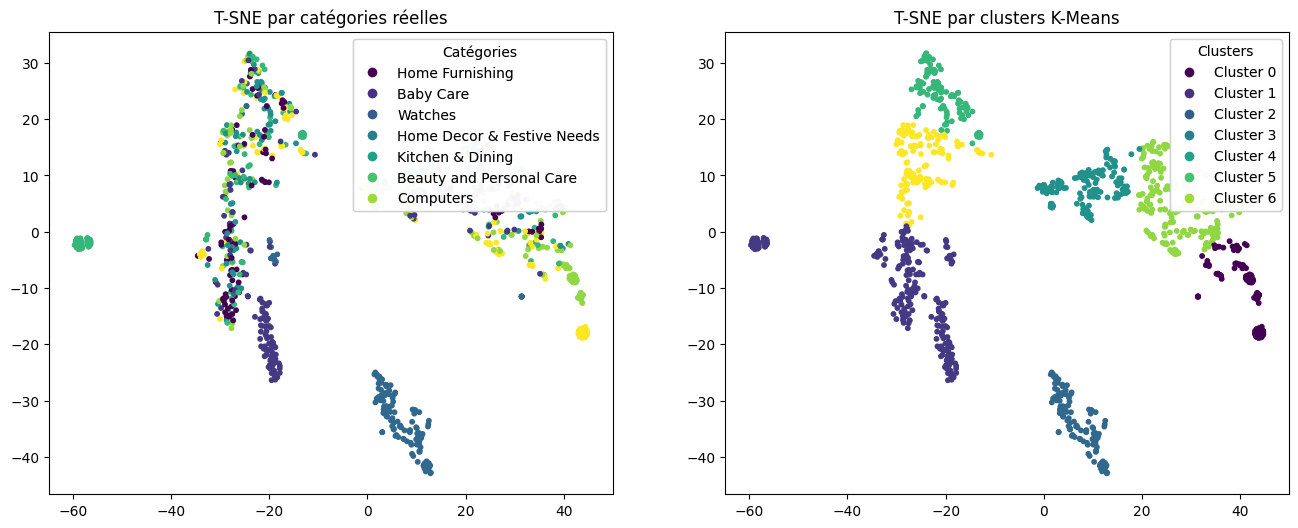

Word2Vec sur la description avec lemmatisation
Nombre de composantes après PCA pour capturer 99.0% de la variance : 4
ARI Score : 0.19401779568552915


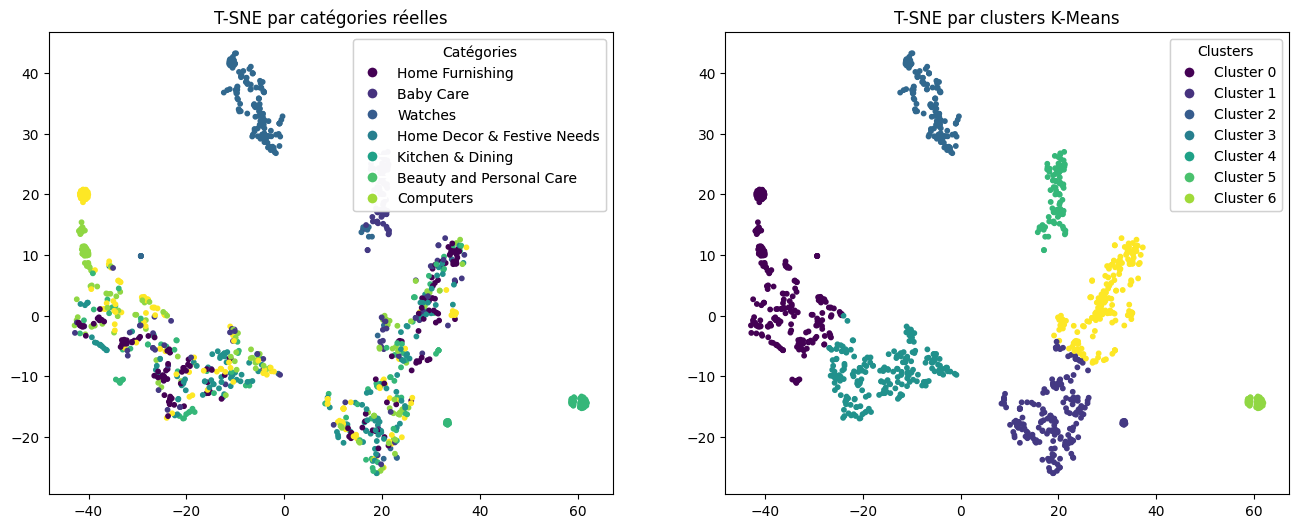

Word2Vec sur la description avec stemming
Nombre de composantes après PCA pour capturer 99.0% de la variance : 4
ARI Score : 0.1962929215871327


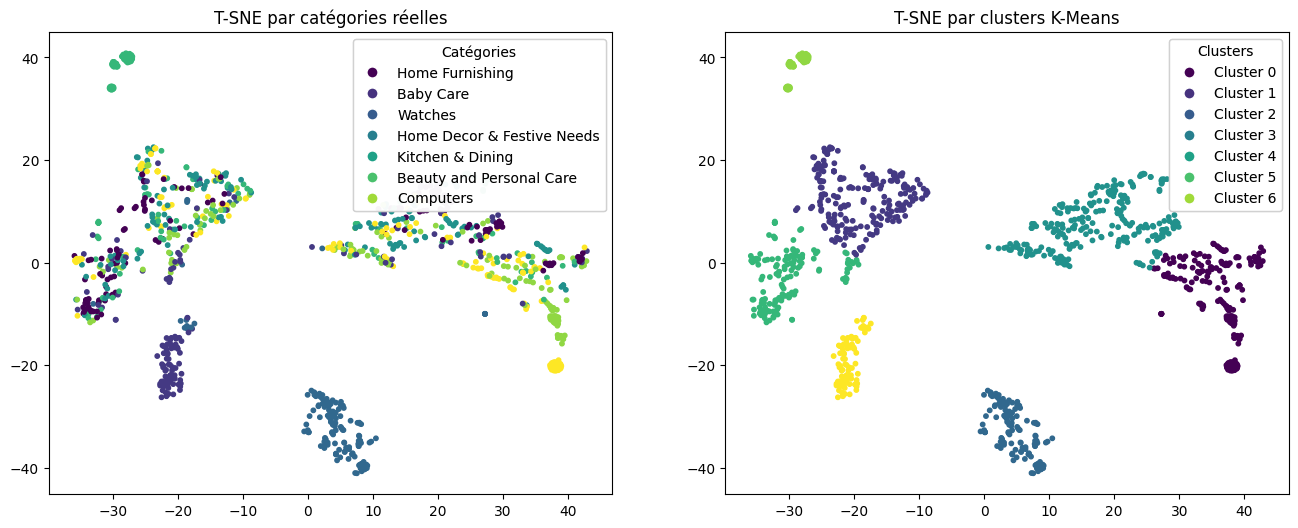

In [ ]:
# Pour Word2Vec
print("Word2Vec sur la description sans lemmatisation")
apply_word2vec(df['descr_bow'])

print("Word2Vec sur la description avec lemmatisation")
apply_word2vec(df['descr_bow_lem'])

print("Word2Vec sur la description avec stemming")
apply_word2vec(df['descr_bow_stem'])

#### <font color='green'>3.1.2 BERT</font><a class="anchor" id="partie3.1.2">

BERT sur la description sans lemmatisation


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Nombre de composantes après PCA pour capturer 99.0% de la variance : 239
ARI Score : 0.4169725521214127


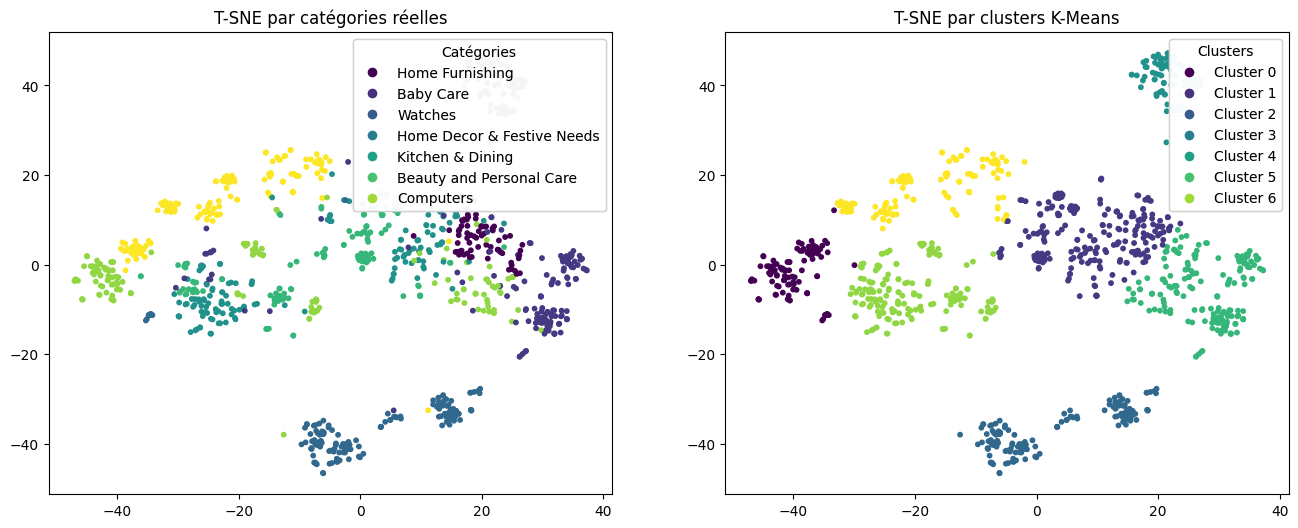

BERT sur la description avec lemmatisation


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Nombre de composantes après PCA pour capturer 99.0% de la variance : 236
ARI Score : 0.2821705292929257


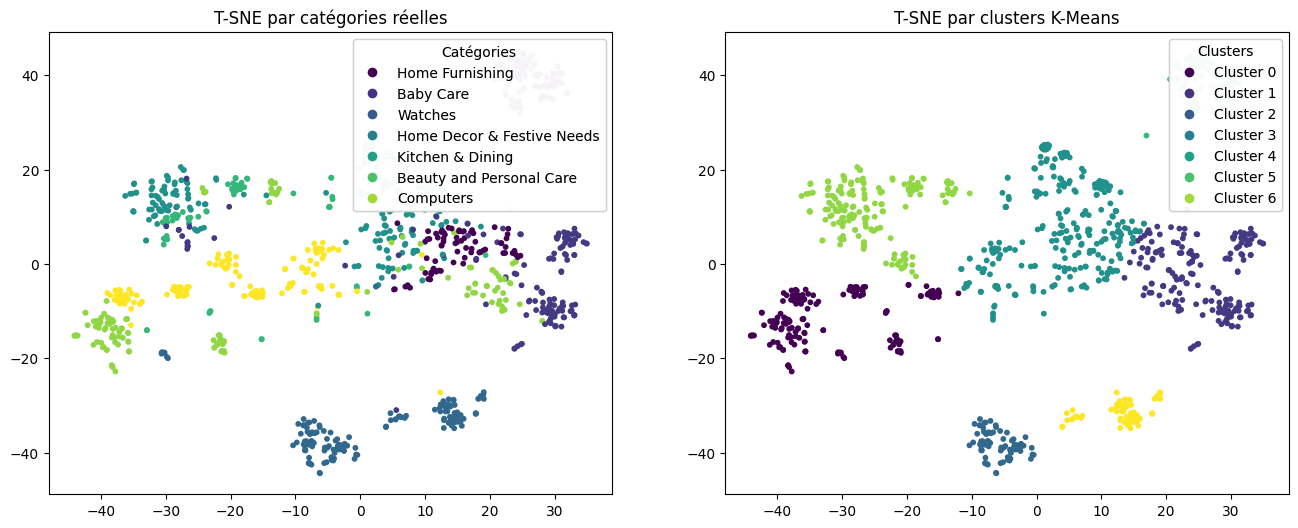

BERT sur la description sans stemming


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Nombre de composantes après PCA pour capturer 99.0% de la variance : 234
ARI Score : 0.37084000147834834


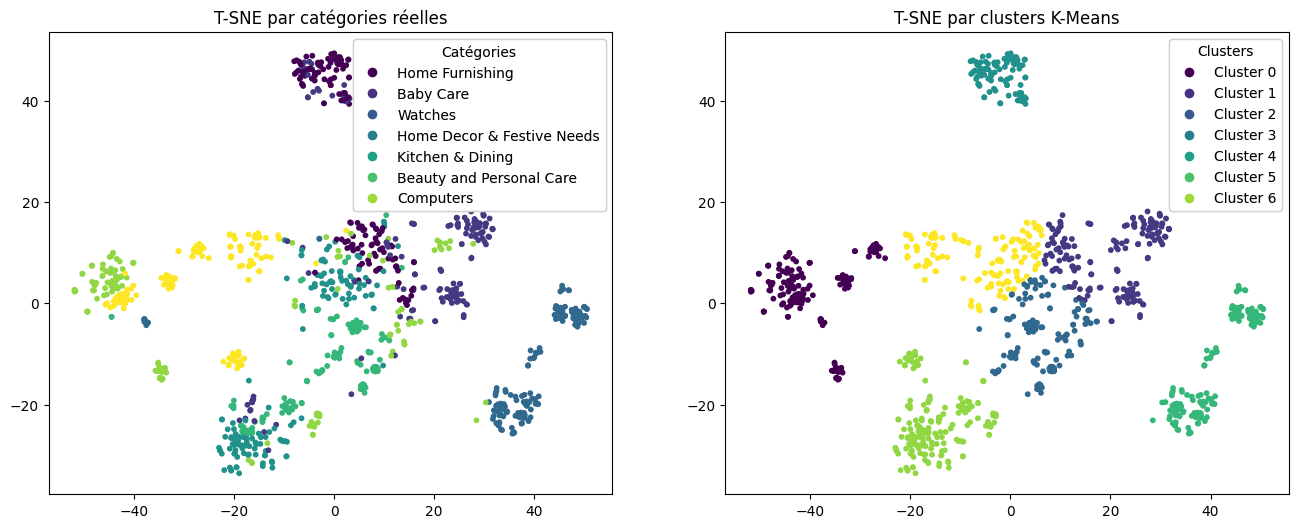

In [ ]:
print("BERT sur la description sans lemmatisation")
apply_bert(df['descr_bow'])
print("BERT sur la description avec lemmatisation")
apply_bert(df['descr_bow_lem'])
print("BERT sur la description sans stemming")
apply_bert(df['descr_bow_stem'])

#### <font color='green'>3.1.3 USE</font><a class="anchor" id="partie3.1.3">

USE sur la description sans lemmatisation
Génération des embeddings USE...
Nombre de composantes après PCA pour capturer 99.0% de la variance : 322
ARI Score : 0.3925993164537121


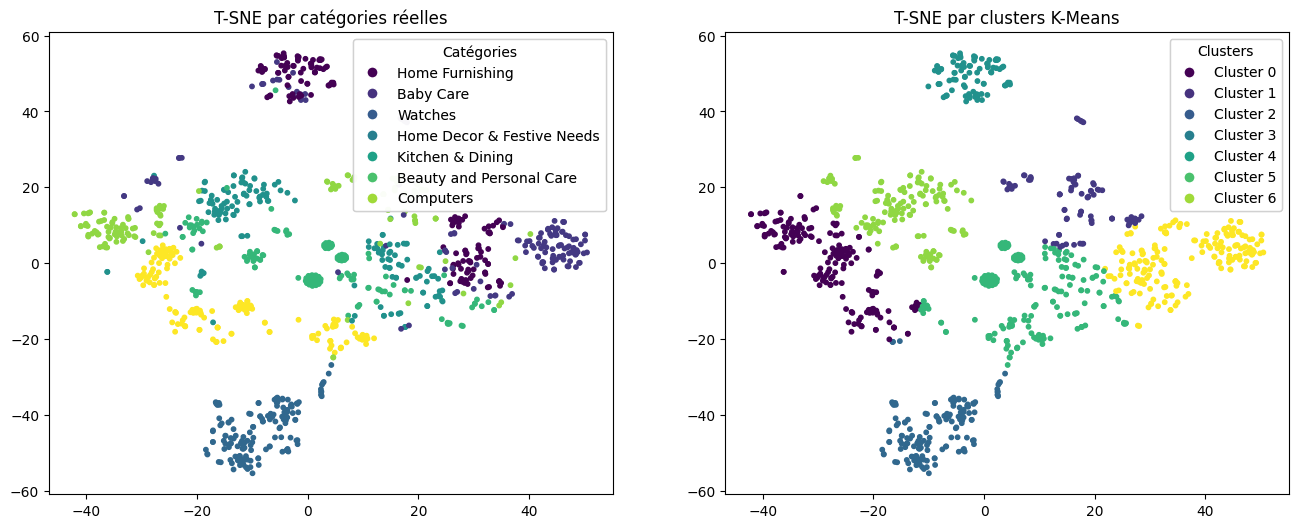

USE sur la description avec lemmatisation
Génération des embeddings USE...
Nombre de composantes après PCA pour capturer 99.0% de la variance : 322
ARI Score : 0.4129403360564476


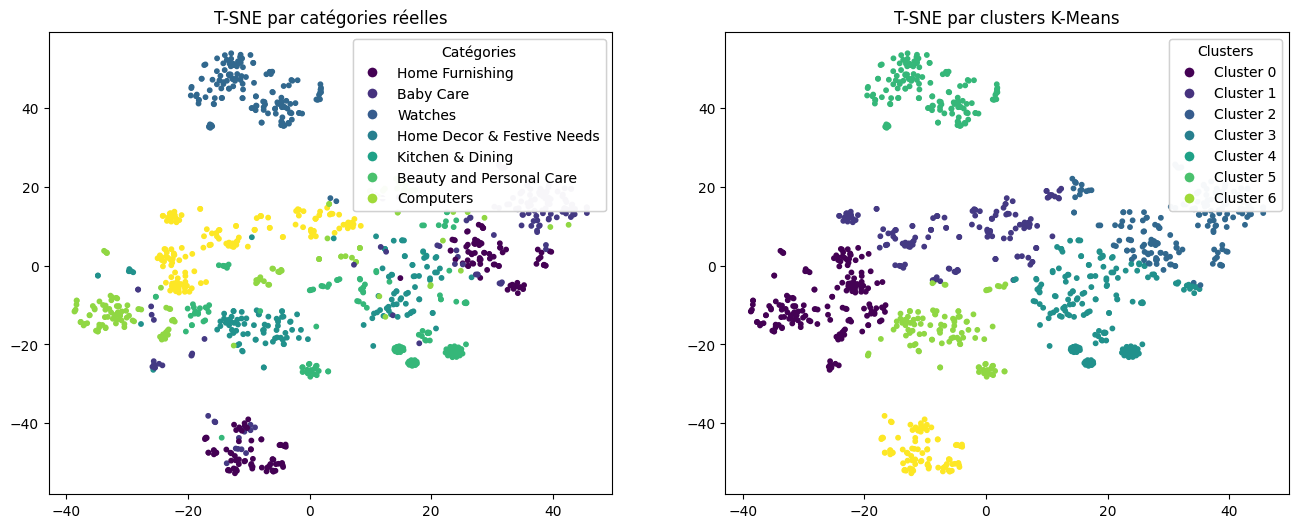

USE sur la description avec stemming
Génération des embeddings USE...
Nombre de composantes après PCA pour capturer 99.0% de la variance : 313
ARI Score : 0.3680272410472328


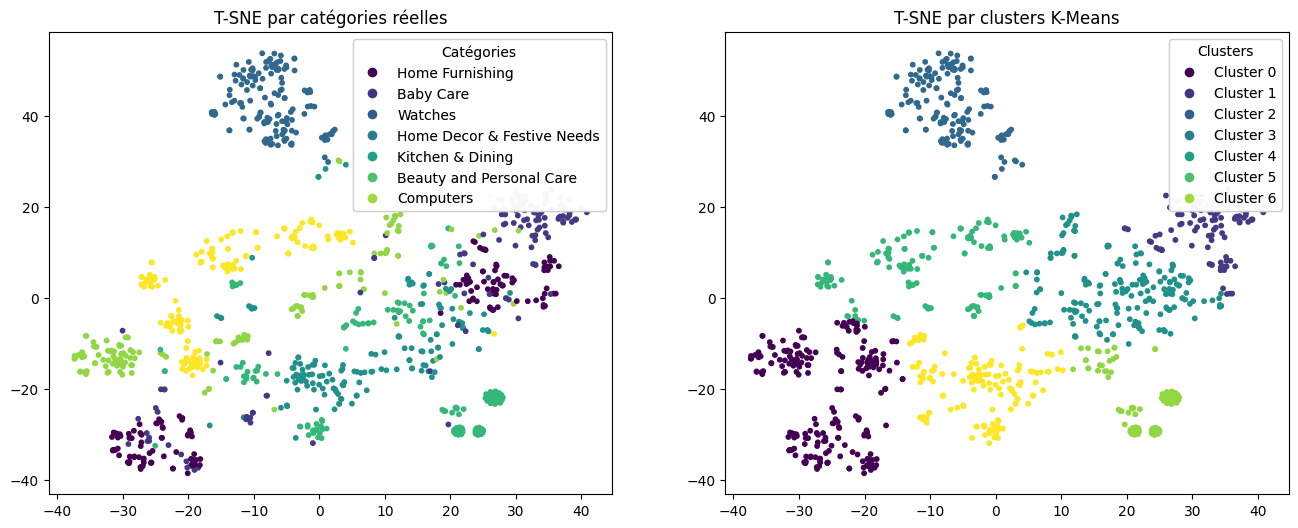

In [ ]:
print("USE sur la description sans lemmatisation")
apply_use(df['descr_bow'])

print("USE sur la description avec lemmatisation")
apply_use(df['descr_bow_lem'])

print("USE sur la description avec stemming")
apply_use(df['descr_bow_stem'])

### <font color='blue'>3.2 Données textuelles : product_name + description</font><a class="anchor" id="partie3.2">

#### <font color='green'>3.2.1 Word2Vec</font><a class="anchor" id="partie3.2.1">

Word2Vec sur product_name + description sans lemmatisation
Nombre de composantes après PCA pour capturer 99.0% de la variance : 5
ARI Score : 0.14234391135055444


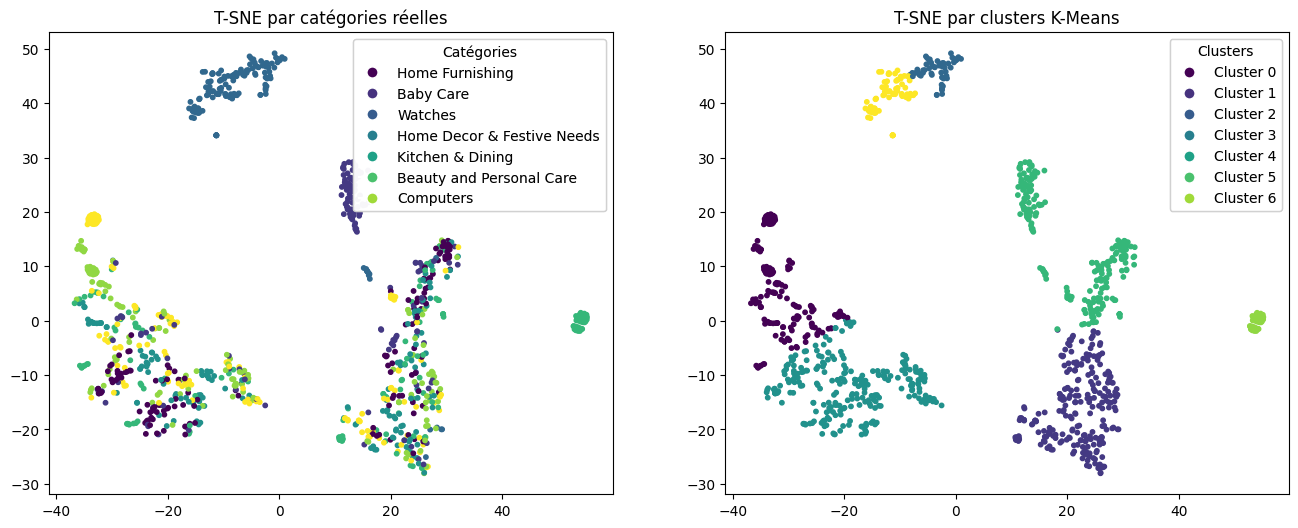

Word2Vec sur product_name + description avec lemmatisation
Nombre de composantes après PCA pour capturer 99.0% de la variance : 4
ARI Score : 0.2041929660978831


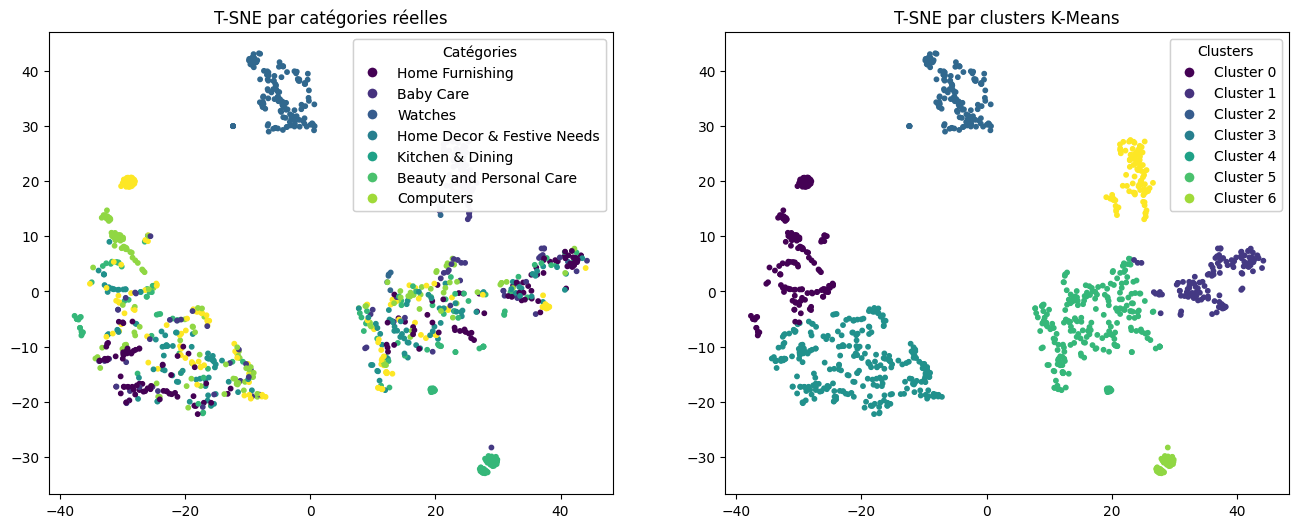

Word2Vec sur product_name + description avec stemming
Nombre de composantes après PCA pour capturer 99.0% de la variance : 4
ARI Score : 0.21347884755755825


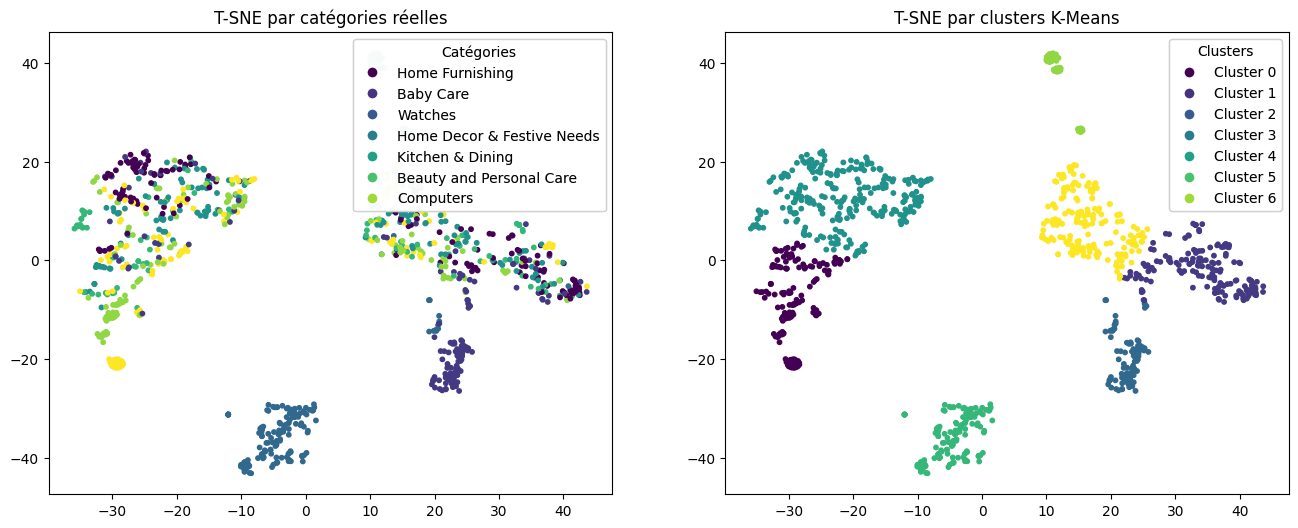

In [ ]:
print("Word2Vec sur product_name + description sans lemmatisation")
apply_word2vec(df['combined_bow'])

print("Word2Vec sur product_name + description avec lemmatisation")
apply_word2vec(df['combined_bow_lem'])

print("Word2Vec sur product_name + description avec stemming")
apply_word2vec(df['combined_bow_stem'])

#### <font color='green'>3.2.2 BERT</font><a class="anchor" id="partie3.2.2">

BERT sur product_name + description sans lemmatisation


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Nombre de composantes après PCA pour capturer 99.0% de la variance : 250
ARI Score : 0.33033132190442027


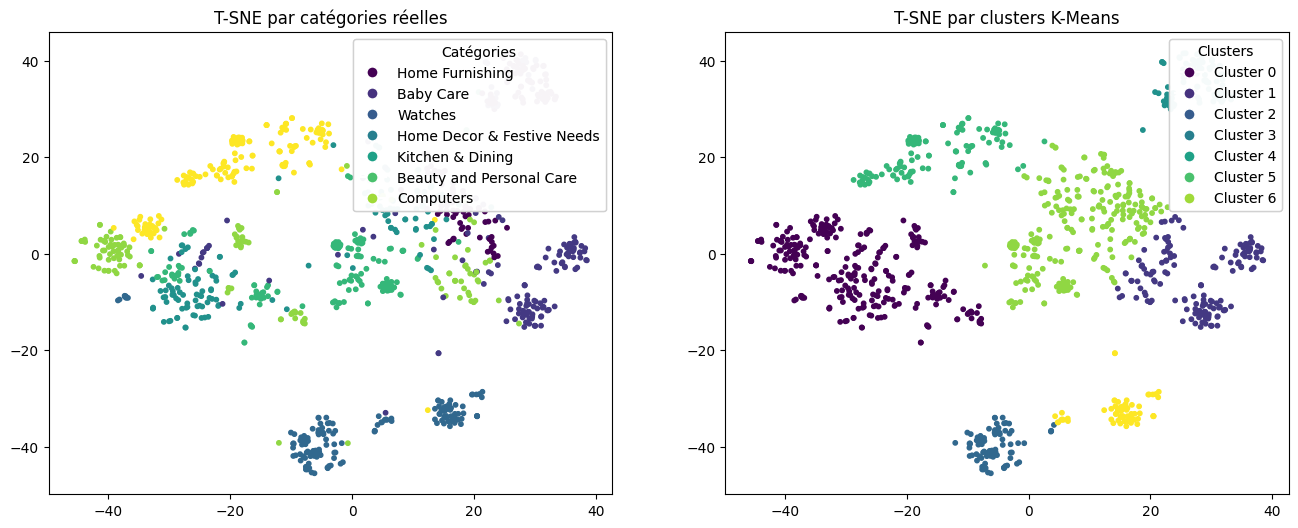

BERT sur product_name + description avec lemmatisation


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Nombre de composantes après PCA pour capturer 99.0% de la variance : 247
ARI Score : 0.41115230675719927


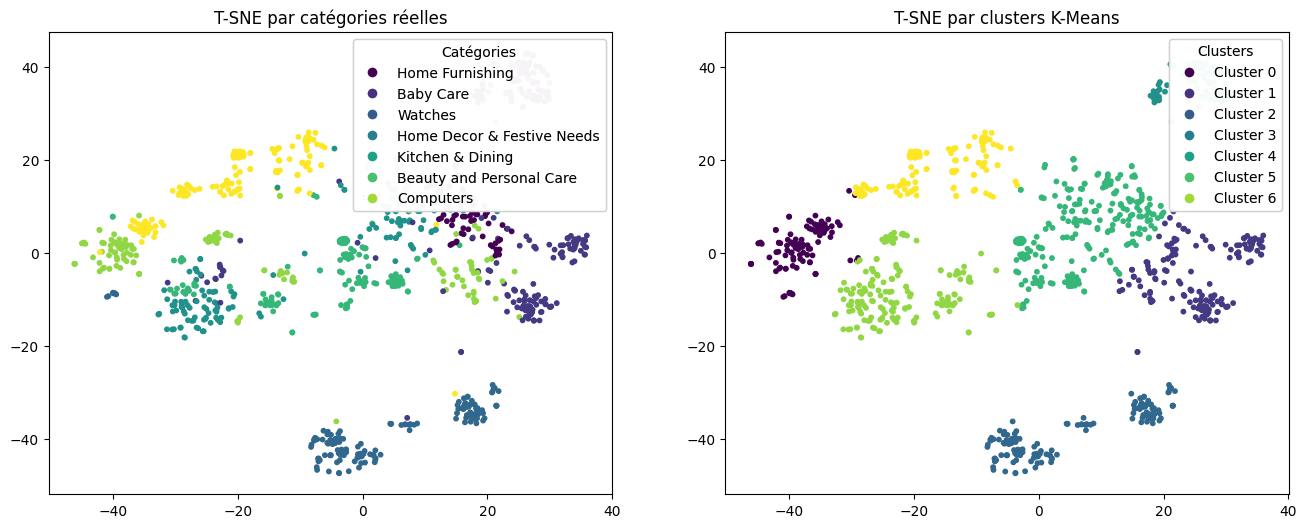

BERT sur product_name + description avec stemming


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Nombre de composantes après PCA pour capturer 99.0% de la variance : 245
ARI Score : 0.31324657471743916


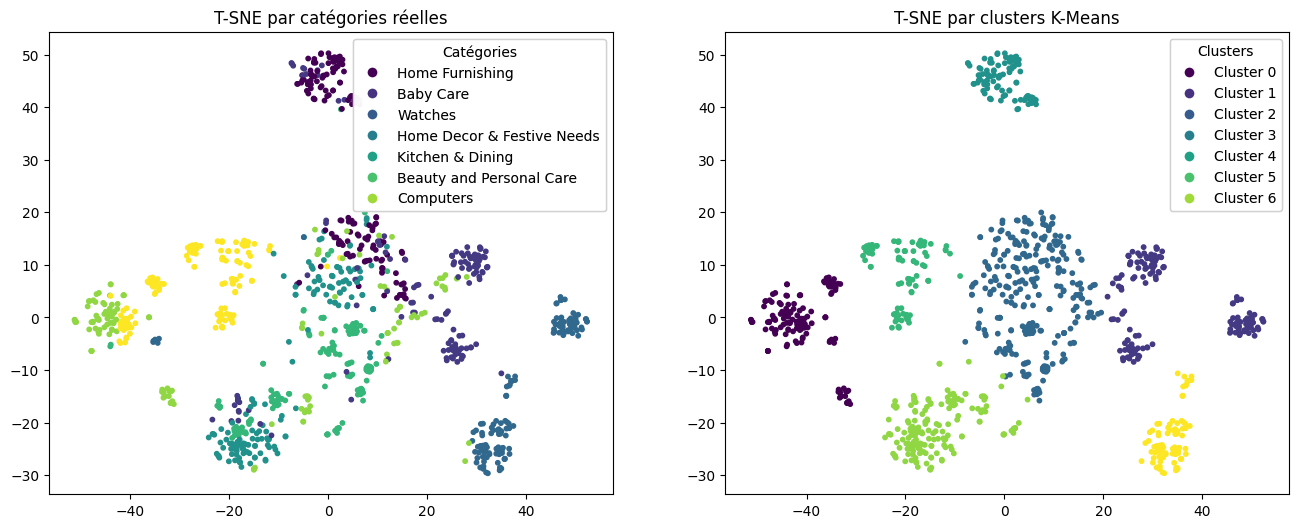

In [ ]:
print("BERT sur product_name + description sans lemmatisation")
apply_bert(df['combined_bow'])

print("BERT sur product_name + description avec lemmatisation")
apply_bert(df['combined_bow_lem'])

print("BERT sur product_name + description avec stemming")
apply_bert(df['combined_bow_stem'])

#### <font color='green'>3.2.3 USE</font><a class="anchor" id="partie3.2.3">

USE sur product_name + description sans lemmatisation
Génération des embeddings USE...
Nombre de composantes après PCA pour capturer 99.0% de la variance : 346
ARI Score : 0.5114839208366905


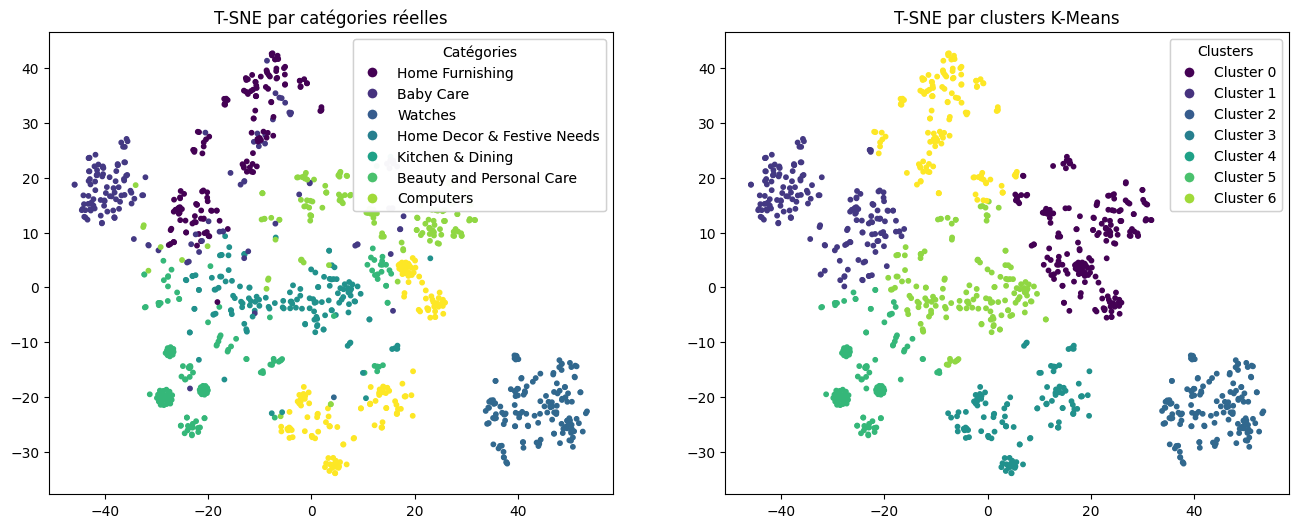

USE sur product_name + description avec lemmatisation
Génération des embeddings USE...
Nombre de composantes après PCA pour capturer 99.0% de la variance : 346
ARI Score : 0.4549558707177538


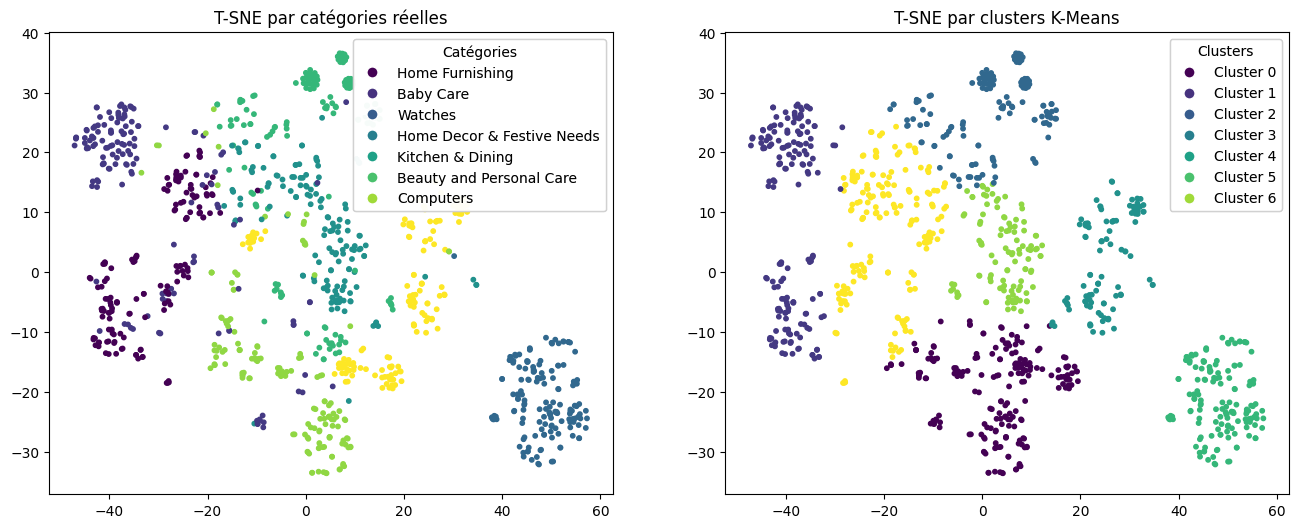

USE sur product_name + description avec stemming
Génération des embeddings USE...
Nombre de composantes après PCA pour capturer 99.0% de la variance : 338
ARI Score : 0.4188724833558063


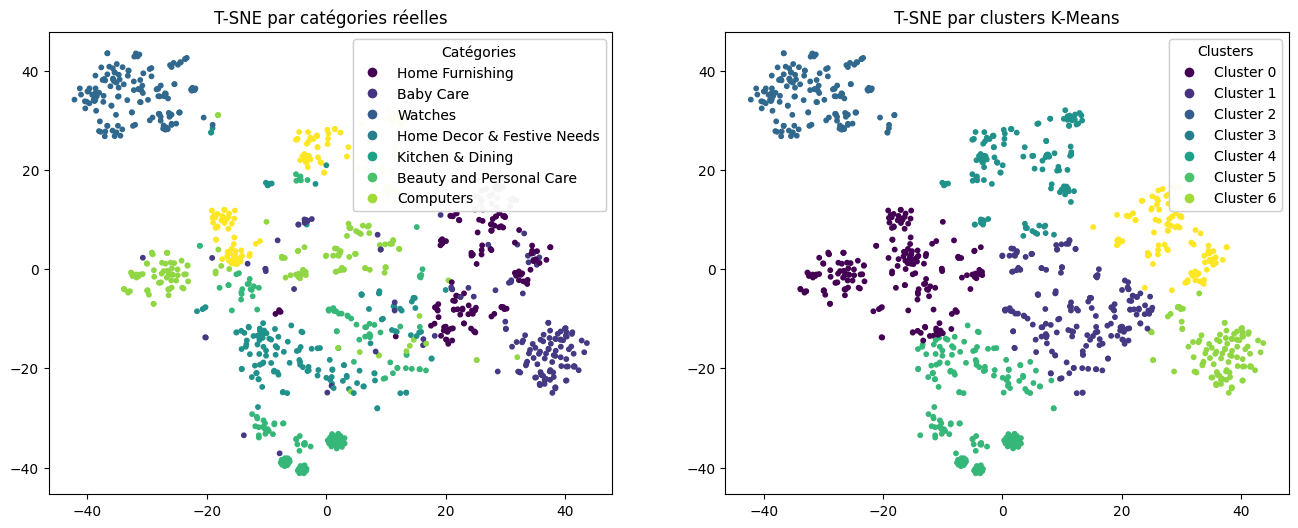

In [ ]:
print("USE sur product_name + description sans lemmatisation")
apply_use(df['combined_bow'])

print("USE sur product_name + description avec lemmatisation")
apply_use(df['combined_bow_lem'])

print("USE sur product_name + description avec stemming")
apply_use(df['combined_bow_stem'])

### <font color='blue'>3.3 Résultats</font><a class="anchor" id="partie3.3">

In [ ]:
# Créer un dictionnaire avec les résultats
data = {
    'Approche': [
        'Word2Vec', 'Word2Vec', 'Word2Vec',
        'BERT', 'BERT', 'BERT',
        'USE', 'USE', 'USE',
        'Word2Vec', 'Word2Vec', 'Word2Vec',
        'BERT', 'BERT', 'BERT',
        'USE', 'USE', 'USE'
    ],
    'Texte': [
        'description', 'description_lem', 'description_stem',
        'description', 'description_lem', 'description_stem',
        'description', 'description_lem', 'description_stem',
        'combined_text', 'combined_text_lem', 'combined_text_stem',
        'combined_text', 'combined_text_lem', 'combined_text_stem',
        'combined_text', 'combined_text_lem', 'combined_text_stem'
    ],
    'Nombre de composantes PCA': [
        4, 4, 4,
        236, 236, 234,
        322, 322, 313,
        5, 4, 4,
        250, 247, 245,
        346, 346, 338
    ],
    'ARI Score': [
        0.185983013, 0.174979465, 0.193920629,
        0.282170529, 0.282170529, 0.370840001,
        0.393493598, 0.409550051, 0.408392880,
        0.192054992, 0.212730133, 0.210752573,
        0.330331322, 0.411152307, 0.313246575,
        0.500326556, 0.4803247368828084, 0.455647231
    ]
}

# Créer un DataFrame
df_results = pd.DataFrame(data)

# Afficher le DataFrame
df_results

,Approche,Texte,Nombre de composantes PCA,ARI Score
0,Word2Vec,description,4,0.185983
1,Word2Vec,description_lem,4,0.174979
2,Word2Vec,description_stem,4,0.193921
3,BERT,description,236,0.282171
4,BERT,description_lem,236,0.282171
5,BERT,description_stem,234,0.370840
6,USE,description,322,0.393494
7,USE,description_lem,322,0.409550
8,USE,description_stem,313,0.408393
9,Word2Vec,combined_text,5,0.192055


#### <font color='purple'>Observations</font>

1. Comparaison des techniques d'embeddings :

- Word2Vec a globalement des résultats inférieurs par rapport à BERT et USE, avec des ARI scores variant entre 0.17 et 0.21, ce qui montre qu'il n'est pas aussi performant pour la séparation des clusters.
- BERT donne de meilleurs résultats que Word2Vec, en particulier sur les données product_name + description où l'ARI atteint jusqu'à 0.41.
- USE (Universal Sentence Encoder) est la technique d'embedding la plus performante, avec des ARI scores atteignant 0.50 sur product_name + description sans lemmatisation. Cela montre que USE est très efficace pour capter les représentations textuelles dans ce projet.

2. Impact du prétraitement (lemmatisation et stemming) :

- Pour Word2Vec, le stemming donne légèrement de meilleurs résultats que la lemmatisation ou l'absence de prétraitement. L'ARI augmente légèrement, mais l'écart n'est pas significatif.
- Pour BERT, le lemmatisation semble donner les meilleurs résultats, avec des ARI scores plus élevés, surtout pour product_name + description.
- USE donne de meilleurs résultats sans lemmatisation pour product_name + description, mais les scores avec et sans stemming sont très proches. Cela suggère que le modèle USE capte bien les informations contextuelles, indépendamment du prétraitement.

3. Données textuelles :

- Les données combinées product_name + description donnent généralement de meilleurs résultats pour toutes les techniques d'embeddings par rapport à la seule colonne description.
- Cela montre l'importance d'utiliser plusieurs sources d'informations textuelles pour améliorer la séparation entre les clusters.

4. Variance capturée par PCA :

- Le nombre de composantes pour capturer 99% de la variance varie beaucoup en fonction de la technique utilisée. Par exemple, BERT et USE nécessitent beaucoup plus de composantes que Word2Vec pour atteindre 99% de la variance. Cela indique que les embeddings BERT et USE sont plus complexes et capturent plus de dimensions d'information.



## <font color='red'>4. Conclusion</font><a class="anchor" id="partie4"></a>

Les résultats montrent que USE est la technique d'embedding la plus performante, suivie de près par BERT. Word2Vec est moins performant pour ce type de tâche, probablement parce qu'il n'est pas aussi sophistiqué pour capturer les relations sémantiques à un niveau plus profond.

Le prétraitement joue un rôle modéré dans les performances, mais les différences ne sont pas extrêmement significatives. Il est intéressant de noter que l'approche product_name + description est largement plus performante que l'utilisation de description seule.

Cela confirme la faisabilité de la classification automatique basée sur des techniques d'embeddings avancées comme BERT et USE.